# NPL Natural Disasters

In [1]:
%%capture

import collections
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
# import scattertext as st

from unidecode import unidecode

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
)

from sklearn.model_selection import train_test_split, cross_val_score

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("words")
nltk.download("stopwords")


# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_trf


2022-12-03 20:37:41.764138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 20:37:41.800046: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# load datasets

df_train = pd.read_csv("data/train.csv")
df_train["train"] = 1
df_test = pd.read_csv("data/test.csv")
df_test["train"] = 0
df = pd.concat([df_train, df_test], axis=0)
df


,id,keyword,location,text,target,train
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,0
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,0
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,0
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,0


## Data Cleaning

In [3]:
# perform data cleaning

# 1. convert all letters to lowercase, so capitalization does not influence word frequency
df["text_cleaned"] = df["text"].str.lower()

# 2. remove @mention
df["text_cleaned"] = df["text_cleaned"].str.replace("@\w+|.@\w+", "", regex=True)

# 3. remove emoji
# credit: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F600-\U0001F64F", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F300-\U0001F5FF", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F680-\U0001F6FF", "", regex=True
)
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "\U0001F680-\U0001F6FF", "", regex=True
)

# 4. remove non alphabetical characters
df["text_cleaned"] = df["text_cleaned"].str.replace("/[^\x00-\x7F]+/", "", regex=True)

# 4. remove special character referencing starting with &
df["text_cleaned"] = df["text_cleaned"].str.replace("&[a-z]+;?", "", regex=True)

# 5. remove http and https links
df["text_cleaned"] = df["text_cleaned"].str.replace(
    "((?:http|https):\/\/[-\w\d+=&@#\/%?~|!:;\.,]*)", "", regex=True
)

# 6. remove punctuations with a space, except for apostrophes
# note that many text do not have space after punctuations, to prevent joining separate words, replace with space
df["text_cleaned"] = df["text_cleaned"].str.replace("[^\w\s']", " ", regex=True)

# 7. translate non ascii text to closest representation
# credit: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string
df["text_cleaned"] = df["text_cleaned"].apply(lambda x: unidecode(x))

# 8. remove blocks of numbers
df["text_cleaned"] = df["text_cleaned"].str.replace("\d+", " ", regex=True)

# 9. remove extra white spaces before after sentences, as well as between words
df["text_cleaned"] = df["text_cleaned"].str.replace("\s+", " ", regex=True)

# 10. remove misc bad letters or invalid letter blocks
df["text_cleaned"] = df["text_cleaned"].str.replace("u_", " ")

# 11. finally stripe all leading and ending whitespaces and numbers
df["text_cleaned"] = df["text_cleaned"].str.strip("123.!? \n\t")


After the above 9 simple data cleaning, most of our tweets are free of invalid characters and text strings. There are still two issues remain:

* **misspelling of words**: a number of words provided in the dataset had been misspelled. Without correcting word spelling, the misspelled words will likely be either discarded during feature engineering and selection, and have little predictive power if included.
* **retweets and nearly identical tweets**: identical tweets and retweets can bias the dataset toward a specific set of words and phrases. It's better if identical copy or very similar tweets are removed.


In [4]:
# # To fix mispelling of words, we cab use jaccard_distance.
# def sentenceSpellCorrect(sentence):

#     # credit: https://www.geeksforgeeks.org/correcting-words-using-nltk-in-python/
#     # list of incorrect spellings
#     # that need to be corrected
#     check_words = sentence.split(" ")
#     new_words = []

#     # loop for finding correct spellings
#     # based on jaccard distance
#     # and printing the correct word
#     for word in check_words:
#         try:
#             temp = [
#                 (jaccard_distance(set(ngrams(word, 2)), set(ngrams(w, 2))), w)
#                 for w in correct_words
#                 if w[0] == word[0]
#             ]
#             new = sorted(temp, key=lambda val: val[0])[0][1]
#             if word != new:
#                 print(f"{word} has been corrected to {new}")
#             new_words.append(new)

#         except:
#             print(f"error occurred when processing sentence: '{sentence}'")
#     new_sentence = " ".join(new_words)
#     return new_sentence


# global correct_words
# correct_words = words.words()
# df["text_cleaned"] = df["text_cleaned"].apply(lambda x: sentenceSpellCorrect(x))


at the end of data cleaning, separate test and train datasets


In [5]:
df_train = df[df.train == 1]
df_train.head(5)


,id,keyword,location,text,target,train,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1,just got sent this photo from ruby alaska as s...


In [6]:
df_test = df[df.train == 0]
df_test.head(5)


,id,keyword,location,text,target,train,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,NaN,0,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN,0,heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN,0,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NaN,0,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN,0,typhoon soudelor kills in china and taiwan


In [7]:
# for the rest of the project, we will no longer be using df_test, so set df_train to df
df = df_train


## Task 1: Bag of words model

A bag of words model is a simple method of processing text data where a string of text (document) is converted to an array of words. These words are then insert into a collection with no specific order. A count of the words by category can reveal what type of words are most frequently occurring by category.

The bag of words is also known as unigrams and can be used as features into predictive models for classification and clustering. In our exercise, we ran through the full set of unigrams generated with a simple feature selection for low sample size (1 occurrence only) and with a variance threshold of 0.005. This removes a number of features that provide little information and differentiation in our model, and prevents overfitting.

Finally, a simple logistic regression model is used to model the label for disaster tweets. The default `L2` penalty term is used so we can use the `lbfgs` solver for faster model convergence.

### 1A. Build bag of words / unigrams (Feature Engineering)

In [8]:
# iterate through the entire training df and build bag of words (tokens) for target == 1 and target == 0

bag_target_0 = []
for sentence in list(df[df.target == 0]["text_cleaned"]):
    tokens = word_tokenize(sentence)
    bag_target_0 = bag_target_0 + tokens

bag_target_1 = []
for sentence in list(df[df.target == 1]["text_cleaned"]):
    tokens = word_tokenize(sentence)
    bag_target_1 = bag_target_1 + tokens


In [9]:
# perform preprocessing to further clean the word list

# three main preprocessing are done on tokens or word list
# 1. remove non alphanumeric characters or symbols that slip through data cleaning
# 2. remove any stop words like the, a, etc. that are present for grammatical reasons and are semantically meaningful
# 3. convert similar words together via Lemmatization, such that the base word is used
wordnet = WordNetLemmatizer()

bag_target_0_processed = bag_target_0
bag_target_0_processed = [i for i in bag_target_0_processed if i.isalpha()]
bag_target_0_processed = [
    i for i in bag_target_0_processed if i not in stopwords.words("english")
]
bag_target_0_processed = [wordnet.lemmatize(i) for i in bag_target_0_processed]
count_bag_target_0_processed = collections.Counter(bag_target_0_processed)
# count_bag_target_0_processed.most_common(10)

bag_target_1_processed = bag_target_1
bag_target_1_processed = [i for i in bag_target_1_processed if i.isalpha()]
bag_target_1_processed = [
    i for i in bag_target_1_processed if i not in stopwords.words("english")
]
bag_target_1_processed = [wordnet.lemmatize(i) for i in bag_target_1_processed]
count_bag_target_1_processed = collections.Counter(bag_target_1_processed)
# count_bag_target_1_processed.most_common(10)


In [10]:
# compute frequency of bag of words

count_bag_target_0_processed = dict(
    zip(count_bag_target_0_processed.keys(), count_bag_target_0_processed.values())
)
count_bag_target_1_processed = dict(
    zip(count_bag_target_1_processed.keys(), count_bag_target_1_processed.values())
)

df_bag_target_0 = pd.DataFrame(
    list(count_bag_target_0_processed.items()), columns=["word", "count"]
)
df_bag_target_1 = pd.DataFrame(
    list(count_bag_target_1_processed.items()), columns=["word", "count"]
)

df_bag_target_0["freq"] = df_bag_target_0["count"] / df_bag_target_0["count"].sum()
df_bag_target_1["freq"] = df_bag_target_1["count"] / df_bag_target_1["count"].sum()

df_bag_target_0 = df_bag_target_0.sort_values(by="count", ascending=False)
df_bag_target_0 = df_bag_target_0.reset_index(drop=True)
df_bag_target_1 = df_bag_target_1.sort_values(by="count", ascending=False)
df_bag_target_1 = df_bag_target_1.reset_index(drop=True)


review word count of 10 most common words for non-disaster tweets

In [11]:
df_bag_target_0.head(10)


,word,count,freq
0,like,256,0.007152
1,u,214,0.005978
2,get,184,0.005140
3,new,170,0.004749
4,one,138,0.003855
5,body,117,0.003269
6,time,106,0.002961
7,would,105,0.002933
8,day,104,0.002905
9,video,102,0.002849


review word count of 10 most common words for disaster tweets

In [12]:
df_bag_target_1.head(10)


,word,count,freq
0,fire,266,0.008747
1,u,162,0.005327
2,news,148,0.004867
3,disaster,122,0.004012
4,via,121,0.003979
5,year,112,0.003683
6,california,111,0.003650
7,police,109,0.003584
8,suicide,106,0.003486
9,family,105,0.003453


#### Summary of BOW results

Of the top 10 most common words, we see more words related to disasters like *fire*, *disaster*, *police*, etc in the disaster bag, and more neutral and non disaster words like *get*, *time*, and *would*. From the common words, we can also identify words that are common in both but is generally not very meaningful like *u*, *year*, but occurs frequently. These common words in both bags can introduce confusion for a classification model on predicting disaster tweets.

### 1B. Feature selection

Remove low sample rate features

In [13]:
# to start, remove low occurrence words
# these words occurs so rarely that they have little predictive power

bag_words = bag_target_0_processed + bag_target_1_processed
count_bag_words = collections.Counter(bag_words)

count_bag_words = dict(zip(count_bag_words.keys(), count_bag_words.values()))
df_bag_words = pd.DataFrame(list(count_bag_words.items()), columns=["word", "count"])
LOW_OCCURRENCE_THRESHOLD = 1
df_bag_words = df_bag_words[df_bag_words["count"] > LOW_OCCURRENCE_THRESHOLD]


In [14]:
# build training dataset using bag of words
def buildFeaturesFromWords(df, df_text_col, word_list):
    df = df.copy()
    series_list = []
    for word in word_list:
        # count number of this word in the sentence text
        if len(word) > 1:
            # discard single letter words
            s = df[df_text_col].str.count(word).rename(f"_{word}")
            series_list.append(s)
    return pd.concat([df, pd.concat(series_list, axis=1)], axis=1)


unique_words = list(df_bag_words.word.unique())
# make sure the unique word list is smaller than separate bags
assert (len(df_bag_target_0) + len(df_bag_target_1)) > len(unique_words)

df = buildFeaturesFromWords(df=df, df_text_col="text_cleaned", word_list=unique_words)

# build a list of variable names that correspond to df columns
unigram_list = [f"_{i}" for i in unique_words if len(i) > 1]

df.head(5)


,id,keyword,location,text,target,train,text_cleaned,_man,_love,_fruit,...,_idfire,_scariest,_ekiti,_salvadoran,_exchanging,_exc,_fatally,_ushed,_kashmir,_woodlawn
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,1,our deeds are the reason of this earthquake ma...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,1,forest fire near la ronge sask canada,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,1,all residents asked to 'shelter in place' are ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,1,people receive wildfires evacuation orders in ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,1,just got sent this photo from ruby alaska as s...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Remove variables based on variance threshold

In [15]:
pred_var = "target"
X, y = df[unigram_list], df_train[pred_var]


In [16]:
from sklearn.feature_selection import VarianceThreshold

LOW_VAR_THRESHOLD = 0.005
sel = VarianceThreshold(threshold=LOW_VAR_THRESHOLD)
sel.fit(X)
# print(sel.get_feature_names_out())
print(
    f"by applying a low variance threshold of {LOW_VAR_THRESHOLD}, {len(unigram_list) - len(sel.get_feature_names_out())} out of {len(unigram_list)} variables were removed"
)

selected_unigram_list = list(sel.get_feature_names_out())


by applying a low variance threshold of 0.005, 4668 out of 5626 variables were removed


In [17]:
pred_var = "target"
X, y = df[selected_unigram_list], df_train[pred_var]


### 1C. Logistic regression model

In [18]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mod_log1bow_acc = accuracy_score(y_test, y_pred)
mod_log1bow_f1 = f1_score(y_test, y_pred)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.7721602101116218
              precision    recall  f1-score   support

    disaster       0.78      0.84      0.81       886
      normal       0.76      0.67      0.71       637

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [19]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)
mod_log1bow_acc_train = accuracy_score(y_train, y_pred_within)
mod_log1bow_f1_train = f1_score(y_train, y_pred_within)

print(f"score(within sample): {accuracy_score(y_train, y_pred_within)}")
print(
    classification_report(y_train, y_pred_within, target_names=["disaster", "normal"])
)

print("Confusion matrix format:\n [['TP', 'FP'],\n ['FN', 'TN']]")
print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


score(within sample): 0.8536945812807881
              precision    recall  f1-score   support

    disaster       0.85      0.91      0.88      3456
      normal       0.87      0.78      0.82      2634

    accuracy                           0.85      6090
   macro avg       0.86      0.85      0.85      6090
weighted avg       0.85      0.85      0.85      6090

Confusion matrix format:
 [['TP', 'FP'],
 ['FN', 'TN']]
Confusion matrix for within sample predictions (percentage):
[[51.55993432  5.18883415]
 [ 9.44170772 33.80952381]]


In [20]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[49.04793171  9.12672357]
 [13.65725542 28.1680893 ]]


In [21]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X)
df["prob_1"] = y_pred_all[:, 1]


In [22]:
# this code block has error

# from scattertext import CorpusFromPandas, produce_scattertext_explorer

# nlp = spacy.load("en_core_web_sm")
# corpus = st.CorpusFromPandas(
#     df.sample(1000), category_col="target_name", text_col="text_cleaned", nlp=nlp
# ).build()

# html = st.produce_scattertext_explorer(
#     corpus,
#     category="target_name",
#     category_name="Disaster",
#     not_category_name="Normal",
#     width_in_pixels=1000,
#     minimum_term_frequency=0,
#     transform=st.Scalers.scale,
#     # metadata=df['speaker']
# )
# file_name = "Conventions2012ScattertextScale.html"
# open(file_name, "wb").write(html.encode("utf-8"))
# IFrame(src=file_name, width=1200, height=700)


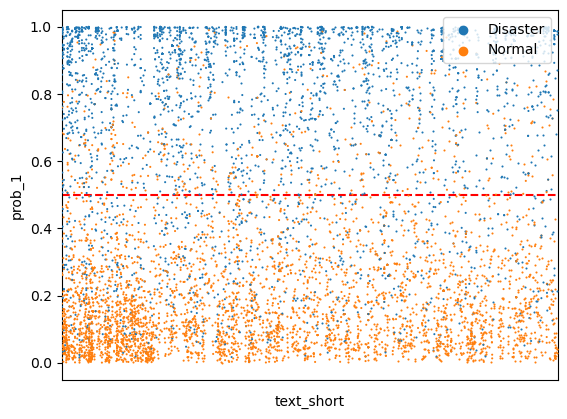

In [23]:
df["text_short"] = df["text_cleaned"].str.slice(0, 6)

fig = sns.stripplot(df, x="text_short", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


There are still a number of misclassification with the simple Logistic Regression model with bag of words.

We hope to improve upon this method by accounting for the importance of words in the dataset using Term Frequency and Inverse Document Frequency (TF-IDF), in the next task.

### 1D. Summary for Log1-BOW Model

Precision (positive predictive value) (TP / [TP + FP]) indicates the fraction of items labelled true in `target` that is actually true. In the **Log1-BOW** model, the positive predictive value of `normal` is *similar to* `disaster`, indicating that the model is not biasd in predicting disaster. Generally, a higher precision could be concerning if we do not have resources to respond to every disaster predicted.

Recall (sensitivity) (TP / [TP + FN]), indicates the fraction of items where are actually true that are labelled "true". The sensitivity of the model at predicting disaster is *much higher* than normal category. This indicate disaster prediction is unlikely to be a false negative. Generally, a higher recall is good if we do not want to miss any real disaster event tweets.

The **Log1-BOW** model, simple logistic regression model using bag of words, features performed reasonably well. However, the confusion matrix for out of sample prediction is noticeably worse than within sample prediction. This can be an indication of overfitting. Additional effort in using cross validation methods (k-fold), and regularization method (ridge classification) that is more robust to overfitting can reduce model overfitting.

## Task 2: Feature generation and traditional ML model with TF-IDF

In [24]:
# clean up dataframe to have the cleaned text, target, and full list of unigram
df = df[["id", "keyword", "location", "text_cleaned", "target"]]
df.shape


(7613, 5)

### 2A. Build ngrams with TF-IDF (Feature Engineering)

In addition to the issue of weighting with bag of words, the use of unigram also means the feature lacks context. For Task 2 with TF-IDF, in addition to unigram, bigrams are generated as a set of features to enhance the ability of models to capture context.

For task 2, the TfidfVectorizer from sklearn is used to generate both ngrams and the TF-IDF score.

_About TF-IDF Score_

TF = (Count of this word in the document) / (Total number of words in the document)
IDF = log {(Total number of document) / [(Number of document containing the word) + 1]}

TF-IDF = TF * IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1, 2),  # unigrams and bigrams
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text_cleaned)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")


vectorization done in 0.086 s
n_samples: 7613, n_features: 3354


In [26]:
vectorizer.get_feature_names_out()


array(['aba', 'aba woman', 'abandoned', ..., 'zionist', 'zombie', 'zone'],
      dtype=object)

To prevent overfitting, we reduce the number of features by setting a higher low variance threshold for bigrams.

In [27]:
# perform feature selection

from sklearn.feature_selection import VarianceThreshold

LOW_VAR_THRESHOLD = 0.0001
sel = VarianceThreshold(threshold=LOW_VAR_THRESHOLD)
sel.fit(X_tfidf)
X_tfidf = sel.transform(X_tfidf)
# print(sel.get_feature_names_out())
print(
    f"by applying a low variance threshold of {LOW_VAR_THRESHOLD}, {len(vectorizer.get_feature_names_out()) - len(sel.get_feature_names_out())} out of {len(vectorizer.get_feature_names_out())} ngram variables were removed"
)

selected_ngram_list = list(sel.get_feature_names_out())

print(f"length of selected_ngram_list: {len(selected_ngram_list)}")


by applying a low variance threshold of 0.0001, 629 out of 3354 ngram variables were removed
length of selected_ngram_list: 2725


### 2B. Logistic regression model

In [28]:
y = df_train[pred_var]

X_tfidf.shape


(7613, 2725)

In [29]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mod_log2idief_acc = accuracy_score(y_test, y_pred)
mod_log2idief_f1 = f1_score(y_test, y_pred)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.7951411687458962
              precision    recall  f1-score   support

    disaster       0.78      0.90      0.84       886
      normal       0.82      0.65      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523



In [30]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)
mod_log2idief_acc_train = accuracy_score(y_train, y_pred_within)
mod_log2idief_f1_train = f1_score(y_train, y_pred_within)

print(f"score(within sample): {accuracy_score(y_train, y_pred_within)}")
print(
    classification_report(y_train, y_pred_within, target_names=["disaster", "normal"])
)

print("Confusion matrix format:\n [['TP', 'FP'],\n ['FN', 'TN']]")
print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


score(within sample): 0.8620689655172413
              precision    recall  f1-score   support

    disaster       0.84      0.94      0.89      3456
      normal       0.91      0.76      0.83      2634

    accuracy                           0.86      6090
   macro avg       0.87      0.85      0.86      6090
weighted avg       0.87      0.86      0.86      6090

Confusion matrix format:
 [['TP', 'FP'],
 ['FN', 'TN']]
Confusion matrix for within sample predictions (percentage):
[[53.4318555   3.31691297]
 [10.47619048 32.77504105]]


In [31]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[52.19960604  5.97504924]
 [14.51083388 27.31451083]]


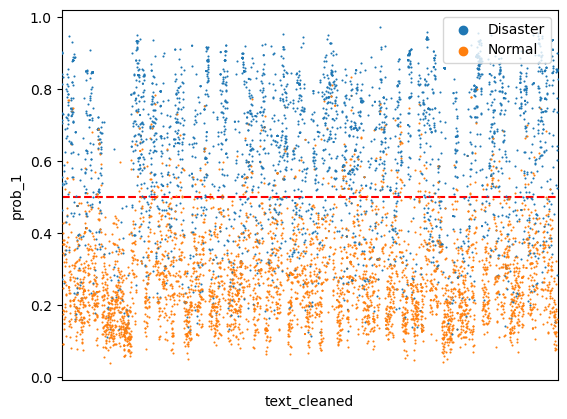

In [32]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X_tfidf)
df["prob_1"] = y_pred_all[:, 1]

fig = sns.stripplot(df, x="text_cleaned", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


### 2C. Summary for Log2-IDIEF Model

Precision (positive predictive value) (TP / [TP + FP]) indicates the fraction of items labelled true in `target` that is actually true. In the **Log2-IDIEF** model, the positive predictive value of `normal` is *higher* than `disaster`, indicating that the model has a bias in predicting normal. Generally, a higher precision could be concerning if we do not have resources to respond to every disaster predicted.

Recall (sensitivity) (TP / [TP + FN]), indicates the fraction of items where are actually true that are labelled "true". The sensitivity of the model at predicting disaster is *much higher* than normal category. This indicate disaster prediction is unlikely to be a false negative. Generally, a higher recall is good if we do not want to miss any real disaster event tweets.

The ngrams with unigrams and bigrams performed better than the simple unigram model (**Log1-BOW**). The accuracy improved from 0.772 to 0.795 for out of sample predictions.

### 2D. Repeat experiment with only Unigram and TF-IDF, and logistic regression

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1, 1),  # unigrams only
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text_cleaned)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")


vectorization done in 0.052 s
n_samples: 7613, n_features: 2464


In [34]:
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, random_state=0, train_size=0.8
)
reg = linear_model.LogisticRegression(solver="lbfgs", max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mod_log1idief_acc = accuracy_score(y_test, y_pred)
mod_log1idief_f1 = f1_score(y_test, y_pred)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.799080761654629
              precision    recall  f1-score   support

    disaster       0.79      0.90      0.84       886
      normal       0.82      0.66      0.73       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [35]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)
mod_log1idief_acc_train = accuracy_score(y_train, y_pred_within)
mod_log1idief_f1_train = f1_score(y_train, y_pred_within)

print(f"score(within sample): {accuracy_score(y_train, y_pred_within)}")
print(
    classification_report(y_train, y_pred_within, target_names=["disaster", "normal"])
)

print("Confusion matrix format:\n [['TP', 'FP'],\n ['FN', 'TN']]")
print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


score(within sample): 0.8628899835796388
              precision    recall  f1-score   support

    disaster       0.84      0.94      0.89      3456
      normal       0.91      0.76      0.83      2634

    accuracy                           0.86      6090
   macro avg       0.87      0.85      0.86      6090
weighted avg       0.87      0.86      0.86      6090

Confusion matrix format:
 [['TP', 'FP'],
 ['FN', 'TN']]
Confusion matrix for within sample predictions (percentage):
[[53.46469622  3.28407225]
 [10.42692939 32.82430213]]


In [36]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[52.13394616  6.04070913]
 [14.05121471 27.77413001]]


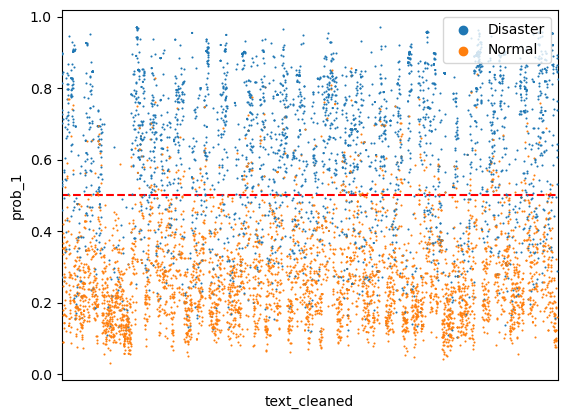

In [37]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X_tfidf)
df["prob_1"] = y_pred_all[:, 1]


fig = sns.stripplot(df, x="text_cleaned", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


### 2E. Summary for Log1-IDIEF Model

Precision (positive predictive value) (TP / [TP + FP]) indicates the fraction of items labelled true in `target` that is actually true. In the **Log1-IDIEF** model, the positive predictive value of `normal` is *higher* than `disaster`, indicating that the model has a bias in predicting normal. Generally, a higher precision could be concerning if we do not have resources to respond to every disaster predicted.

Recall (sensitivity) (TP / [TP + FN]), indicates the fraction of items where are actually true that are labelled "true". The sensitivity of the model at predicting disaster is *much higher* than normal category. This indicate disaster prediction is unlikely to be a false negative. Generally, a higher recall is good if we do not want to miss any real disaster event tweets.

The unigram model with IDIEF (**Log1-IDIEF**) performed better than the simple unigram model (**Log1-BOW**). The accuracy improved from 0.772 to 0.799 for out of sample predictions. Comparing to the unigram and bigram model with IDIEF (**Log2-IDIEF**), the result is very similar with accuracy improved slightly from 0.795 to 0.799. This indicates the use of bigrams is not adding enough information to the model and that the unigrams are sufficient. This is reasonable since most of our document strings are very short (tweets are limited to 280 characters long), so the use of bigrams to add context to words and phrases is not worse the additional computational power, and could potentially worsen overfitting.

## Task 3: Pre-trained word embeddings + linear classifier model

### 3A. Apply pre-trained GloVe embeddings to generate features

In [38]:
%%capture

import tensorflow as tf
from tensorflow import keras

# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

# credit to example: https://keras.io/examples/nlp/pretrained_word_embeddings/

In [39]:
df["rand"] = np.random.rand(len(df))


In [40]:
train_words = df[df.rand > 0.2].text_cleaned
test_words = df[df.rand <= 0.2].text_cleaned
train_labels = df[df.rand > 0.2].target
test_labels = df[df.rand <= 0.2].target


In [41]:
train_words.shape


(6178,)

In [42]:
# # use our cleaned text to build a word index - this generates lots of misses because sentences have not been converted into word strings
# word_index = dict(zip(list(df.text_cleaned), range(len(df))))


We need to perform text vectorization, so we can map our sequence of words as tensors.

In [43]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(train_words).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

X_train = vectorizer(np.array([[s] for s in train_words])).numpy()
X_test = vectorizer(np.array([[s] for s in test_words])).numpy()
X_all = vectorizer(np.array([[s] for s in list(df.text_cleaned)])).numpy()

y_train = np.array(train_labels)
y_test = np.array(test_labels)

vectorizer.get_vocabulary()[-5:]


2022-12-03 20:41:06.994008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['aal', 'aaemiddle', 'aaarrrgghhh', 'aaaaaaallll', 'aaaa']

In [44]:
# word index and voc length should be identical
assert len(voc) == len(word_index)


In [45]:
# read glove word embeddings

path_to_glove_file = os.path.join("./data/glove.6B.100d.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


In [46]:
embeddings_index["a"].shape


(100,)

In [47]:
# build an embedding matrix

num_tokens = len(word_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 10906 words (1865 misses)


In [48]:
# use the prepared embedding matrix to create an embedding layer

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [49]:
# apply glove text embedding

X_train = embedding_layer(X_train)
X_test = embedding_layer(X_test)
X_all = embedding_layer(X_all)

# y_train = np.array(train_labels)
# y_test = np.array(test_labels)


reshape 50 x 100 word embedding features into 5000

In [50]:
X_train.shape


TensorShape([6178, 50, 100])

In [51]:
X_train_old_i0 = X_train[0]
X_train_old_i0


<tf.Tensor: shape=(50, 100), dtype=float32, numpy=
array([[-0.085462,  0.11468 ,  0.63305 , ..., -0.25772 ,  0.57399 ,
         1.4787  ],
       [ 0.43133 , -0.088912, -0.06145 , ..., -0.24217 , -0.53863 ,
        -0.13046 ],
       [-0.51533 ,  0.83186 ,  0.22457 , ..., -1.2024  ,  1.1304  ,
         0.3479  ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)>

In [52]:
X_train = tf.reshape(X_train, shape=(len(X_train), 5000))
X_test = tf.reshape(X_test, shape=(len(X_test), 5000))
X_all = tf.reshape(X_all, shape=(len(X_all), 5000))
X_train[0]


<tf.Tensor: shape=(5000,), dtype=float32, numpy=
array([-0.085462,  0.11468 ,  0.63305 , ...,  0.      ,  0.      ,
        0.      ], dtype=float32)>

In [53]:
# check reshape is done correctly
(tf.reshape(X_train[0], (50, 100)) == X_train_old_i0)


<tf.Tensor: shape=(50, 100), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

In [54]:
# We do not need to apply a full keras model

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten

# vocab_size = 20000
# max_length = 50
# model = Sequential()
# model.add(Embedding(vocab_size, 8, input_length=max_length))
# model.add(Flatten())
# model.add(Dense(1, activation="sigmoid"))
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# print(model.summary())


### 3B. Stochastic gradient descent with glove word embeddings (SGD-Glove)

In [55]:
from sklearn import linear_model

reg = linear_model.SGDClassifier(
    loss="modified_huber", penalty="l2", max_iter=1000, tol=0.001
)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mod_sdgglove_acc = accuracy_score(y_test, y_pred)
mod_sdgglove_f1 = f1_score(y_test, y_pred)
print(f"score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=["disaster", "normal"]))


score: 0.7205574912891987
              precision    recall  f1-score   support

    disaster       0.80      0.69      0.74       836
      normal       0.64      0.76      0.69       599

    accuracy                           0.72      1435
   macro avg       0.72      0.73      0.72      1435
weighted avg       0.73      0.72      0.72      1435



In [56]:
y_pred_within = reg.predict(X_train)
cm = confusion_matrix(y_train, y_pred_within)
mod_sdgglove_acc_train = accuracy_score(y_train, y_pred_within)
mod_sdgglove_f1_train = f1_score(y_train, y_pred_within)

print(f"score(within sample): {accuracy_score(y_train, y_pred_within)}")
print(
    classification_report(y_train, y_pred_within, target_names=["disaster", "normal"])
)

print("Confusion matrix format:\n [['TP', 'FP'],\n ['FN', 'TN']]")
print("Confusion matrix for within sample predictions (percentage):")
print(cm / cm.sum() * 100)


score(within sample): 0.9020718679184202
              precision    recall  f1-score   support

    disaster       0.96      0.87      0.91      3506
      normal       0.84      0.95      0.89      2672

    accuracy                           0.90      6178
   macro avg       0.90      0.91      0.90      6178
weighted avg       0.91      0.90      0.90      6178

Confusion matrix format:
 [['TP', 'FP'],
 ['FN', 'TN']]
Confusion matrix for within sample predictions (percentage):
[[49.15830366  7.59145354]
 [ 2.20135966 41.04888313]]


In [57]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix for out of sample predictions")
print(cm / cm.sum() * 100)


Confusion matrix for out of sample predictions
[[40.34843206 17.90940767]
 [10.03484321 31.70731707]]


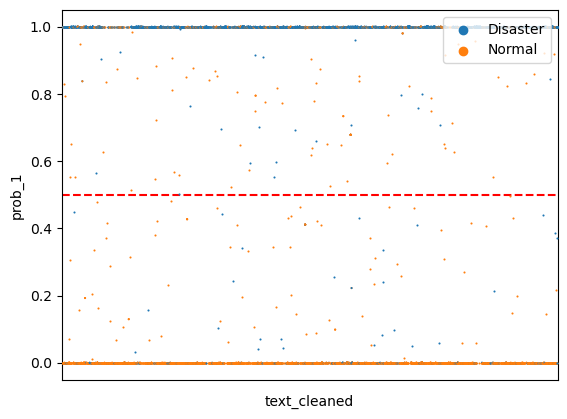

In [58]:
#  evaluate and plot the model

df.loc[df["target"] == 0, "target_name"] = "Normal"
df.loc[df["target"] == 1, "target_name"] = "Disaster"

# generate probability for all samples for plotting
y_pred_all = reg.predict_proba(X_all)
df["prob_1"] = y_pred_all[:, 1]


fig = sns.stripplot(df, x="text_cleaned", y="prob_1", hue="target_name", size=1.5)
# fig.set(xlabel=None)
fig.set(xticklabels=[])
fig.tick_params(bottom=False)
plt.axhline(y=0.5, color="red", linestyle="--")
plt.legend(loc="upper right")


### 3C. Summary for SGD-Glove model

Precision (positive predictive value) (TP / [TP + FP]) indicates the fraction of items labelled true in `target` that is actually true. In the **SGD-Glove** model, the positive predictive value of `normal` is *lower* than `disaster`, indicating that the model has a bias in predicting disaster. Generally, a higher precision could be concerning if we do not have resources to respond to every disaster predicted.

Recall (sensitivity) (TP / [TP + FN]), indicates the fraction of items where are actually true that are labelled "true". The sensitivity of the model at predicting disaster is *higher* than normal category. This indicate disaster prediction is unlikely to be a false negative. Generally, a higher recall is good if we do not want to miss any real disaster event tweets.

Overall, the **SGD-Glove** model performed worse than the previous models. This is especially notable in the difference in accuracy and f1-score between the test and train sample. This is an indication of overfitting due to a large number of feature generated using the Glove pre-trained text embedding. Model more robust to overfitting like ensemble models (gradient boosted trees, and random forest) could be explored with the Glove text embedding in the future.


## Recommendation and Conclusion

**Table 1**: summary of model results for classifying disaster tweets

| Model        | accuracy (test) | accuracy (train) | f1-score* (test) | f1-score* (train) |
|--------------|:---------------:|-----------------:|-----------------:|------------------:|
| Log1-BOW     |      0.772      |       0.854      |        0.71      |         0.82      |
| Log2-IDIEF   |      0.795      |       0.862      |        0.72      |         0.83      |
| Log1-IDIEF   |      0.799      |       0.863      |        0.73      |         0.83      |
| SGD-Glove    |      0.721      |       0.902      |        0.69      |         0.89      |

*The f1 score reported in Table 1 are for disaster category prediction only.

In [59]:
results = {
    "Model": ["Log1-BOW", "Log2-IDIEF", "Log1-IDIEF", "SGD-Glove"],
    "accuracy_test": [
        mod_log1bow_acc,
        mod_log2idief_acc,
        mod_log1idief_acc,
        mod_sdgglove_acc,
    ],
    "accuracy_train": [
        mod_log1bow_acc_train,
        mod_log2idief_acc_train,
        mod_log1idief_acc_train,
        mod_sdgglove_acc_train,
    ],
    "f1-score_test": [
        mod_log1bow_f1,
        mod_log2idief_f1,
        mod_log1idief_f1,
        mod_sdgglove_f1,
    ],
    "f1-score_train": [
        mod_log1bow_f1_train,
        mod_log2idief_f1_train,
        mod_log1idief_f1_train,
        mod_sdgglove_f1_train,
    ],
}

df_results = pd.DataFrame(results)
df_results


,Model,accuracy_test,accuracy_train,f1-score_test,f1-score_train
0,Log1-BOW,0.772160,0.853695,0.712033,0.822120
1,Log2-IDIEF,0.795141,0.862069,0.727273,0.826159
2,Log1-IDIEF,0.799081,0.862890,0.734375,0.827229
3,SGD-Glove,0.720557,0.902072,0.694127,0.893430


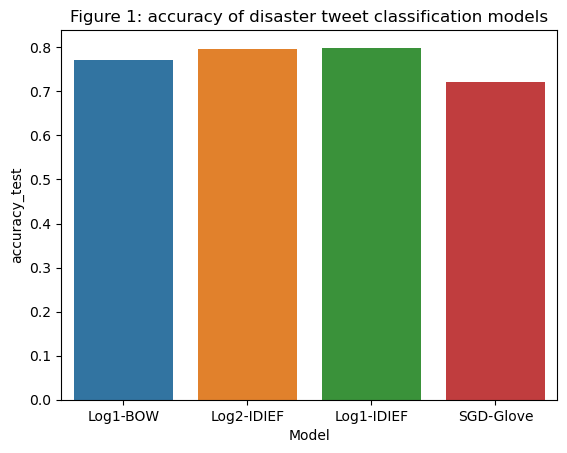

In [60]:
fig = sns.barplot(df_results, x="Model", y="accuracy_test").set_title(
    "Figure 1: accuracy of disaster tweet classification models"
)


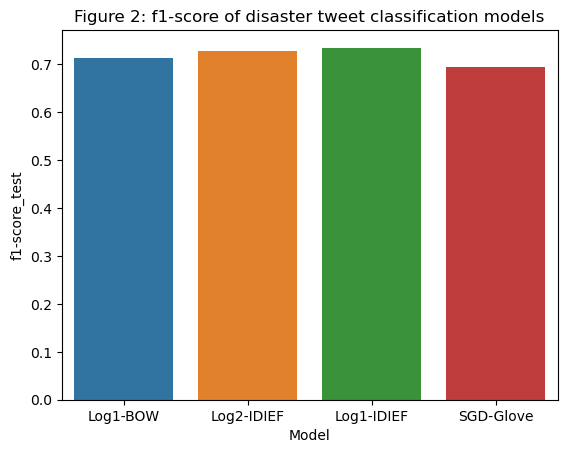

In [61]:
fig = sns.barplot(df_results, x="Model", y="f1-score_test").set_title(
    "Figure 2: f1-score of disaster tweet classification models"
)


In this exercise, we explored various different ways of encoding text strings into features using simple bag of words (unigrams), unigrams and bigrams with ID-IEF, and pre-trained text embedding GloVe. Where possible, we used feature selection to remove variables with low variance to reduce overfitting and to produce a more performant model.

We found that the nature of tweets meant words and phrases are shorter and thus benefit less from having complex text embedding or higher order ngrams. In fact, without using more complex classification techniques like neural networks and ensemble methods, the traditional classification method of logistic regression and SGD-GloVe are too sensitive to noise in the data features, and tend to suffer from overfitting. The extent of overfitting is worsened when we introduce more complex features with GloVe, and the performance of the model did not improve with use of higher order ngrams.

In contrast, the use of ID-IEF did introduce noticeable improvement in our model accuracy. When paired with either ngrams or simple unigrams, the accuracy of these models were around 0.79 in our out of sample prediction, which is much higher than the 0.772 with Bag of words (BOW) and Logistic regression, and 0.721 with SGD-GloVe. The f1 scores for all models were reasonable, with the ID-IEF based model performing best. See Figure 1, Figure 2 and Table 1 above for more detail.

The Log1-IDIEF performed the best among the models tested with IDIEF, and the simple unigrams feature representation was sufficient and is the best choice in terms of model performance and model complexity using Logistic regression. It is also more explainable. Since with Logistic regression and unigrams, it is possible to extract a list simple words that represent the disaster. Therefore, we can "tune" the model coefficient and input variables to help identify words outside of our dataset, when applying the model in the real world. This allow for certain words and phrases (like "danger" or "earthquake" or "floods") to be defined as catch words at certain times (such as periods of extreme rainfall forecast) that we would want to see on the top of our prediction. This is a useful feature, since the use of hashtags and specific words may be  quite popular when a major event is occurring.

## Next Steps

One of the shortcomings of the current recommendation is the lack of consideration for word similarities. This is a useful feature of word embedding that can potentially make the model more scalable to a larger and more complex set of examples. If given more data, we could try more complex feature engineering with word embedding and different types of word vectorization and word embedding. To reduce the impact of model noise, a better feature selection method should be adopted to preprocess the features based on similarity and information gain. Finally, more complex models with more robustness to overfitting should be explored.

The current state of the analysis is very straightforwardly presented (in their order of operations), but is not designed to be modular or easily adapted to different use cases such as deployment to a production system for tweet classification. The content of this notebook can be used to build different functions within a `DisasterTweetClassifier` class. The various functions should be created based on the steps required to build a model with the content of input and output data in mind. For example, based on the content of this notebook, we can first create a data cleaning method, `def data_cleaning()`, that perform a set of common regex and text manipulations. Then, we can create a `def build_features()` method that take raw text document data and convert them into either unigram, bigram, ngrams, or text embeddings. We can add options to the build_feature method to allow for scaling with TF-IDF when it is applicable. We can also build another method that select features based on predefined threshold or conditions such as `def feature_select()`. Finally, we can build a reporting and quality assurance function that print out logs and figures of model performance `def assess_mode_qa()`. By restructuring the code in this straightforwardly presented notebook, we can improve the maintainability of the code and make it easier to scale and deploy our model.